In [1]:
import sys
sys.path.append('../lib')
from table_detection import Pipeline, TableMask, Table, process_column_mask, process_line_mask, LineDetection
from tablenet import TableNet
from openfoodfactsimage import *
from utils import *
import cv2
from shutil import copyfile
import os
import numpy as np
import imutils
import tqdm
import json
from utils import *
import pandas as pd
from collections import namedtuple
Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
model = TableNet.build()
latest = tf.train.latest_checkpoint('C:\\Users\\ytremenbert\\fact-extraction\\TableNet_notebooks\\models\\2021_04_01')
model.load_weights(latest)

In [4]:
images = [os.path.join('C:/Users/ytremenbert/fact-extraction/TableNet_notebooks/new_data_for_test/',file) for file in os.listdir('C:/Users/ytremenbert/fact-extraction/TableNet_notebooks/new_data_for_test/') if file.split('.')[-1]=='jpg']

In [5]:
image = plt.imread(os.path.join('C:/Users/ytremenbert/fact-extraction/TableNet_notebooks/new_data_for_test/',"17e2c8a6-5565-44c0-96f1-0cadbea3b64b-1_cropped.jpg"))

In [6]:
%%time
col_config = {'widnow_size':20,'min_distance_between_peaks':10,'method':'std'} #'method' : 'std'
line_config = {'widnow_size':20,'min_distance_between_peaks':20,'method':'variance'} #CONFIG RAJOUTEE PAR YANN (trouvée dans 3-pipeline.ipynb)
pipeline = Pipeline(model,image)
pipeline.run(0.8)
table = Table(pipeline.predicted_column_mask,pipeline.predicted_line_mask,image.shape)
table.find_table(col_config, line_config)

Wall time: 2.56 s


In [7]:
img_height, img_width = 256, 256

In [8]:
img = image.copy()
img_decoded = decode_img(tf.io.read_file("C:/Users/ytremenbert/fact-extraction/TableNet_notebooks/new_data_for_test/17e2c8a6-5565-44c0-96f1-0cadbea3b64b-1_cropped.jpg"))[0]
#img_norm = normalize(decode_img(tf.io.read_file("C:/Users/ytremenbert/fact-extraction/TableNet_notebooks/new_data_for_test/17e2c8a6-5565-44c0-96f1-0cadbea3b64b-1_cropped.jpg")))
#print(img_norm)
img_norm = normalize(img_decoded)

In [9]:
def create_mask(pred_mask1, pred_mask2):
    pred_mask1 = tf.argmax(pred_mask1, axis=-1)
    pred_mask1 = pred_mask1[..., tf.newaxis]
    pred_mask2 = tf.argmax(pred_mask2, axis=-1)
    pred_mask2 = pred_mask2[..., tf.newaxis]
    return pred_mask1[0], pred_mask2[0]

In [10]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for images_batch in dataset.take(num):
            pred_mask1, pred_mask2 = model.predict(images_batch, verbose=1)
            #print(pred_mask1)
            table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
            #print(table_mask)
            display([images_batch[0], table_mask, column_mask])
            #print("dataset path")
    else:
        pred_mask1, pred_mask2 = model.predict(sample_image, verbose=1)
        table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
        display([sample_image[0], table_mask, column_mask])
        print("else path")

1/1 [==============================] - 1s 1s/step


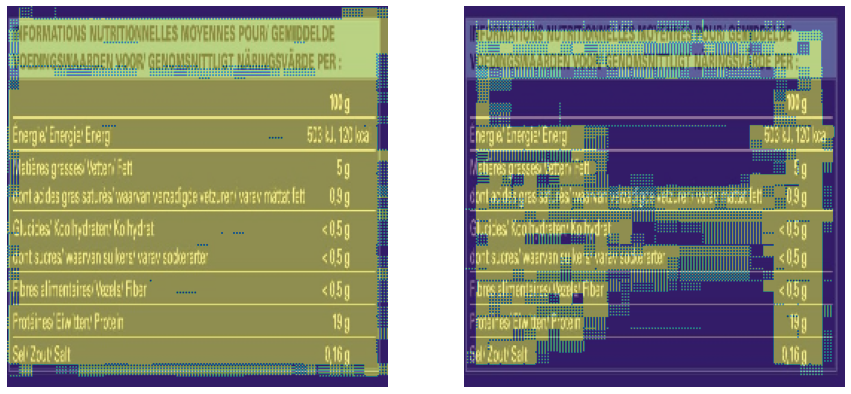

In [11]:
list_ds = tf.data.Dataset.from_tensor_slices([img_norm, img_norm])
test_dataset = list_ds.batch(2)
#print(list_ds)
#print(test_dataset)
#print(test_dataset.take(1))
#plot_predictions(model, list_ds)
show_predictions(dataset=test_dataset, num=1)

In [12]:
for line in table.table:
    for cell in line:
        cv2.rectangle(img,(cell.xmin,cell.ymin),(cell.xmax,cell.ymax),color=(255,0,0),thickness=5)

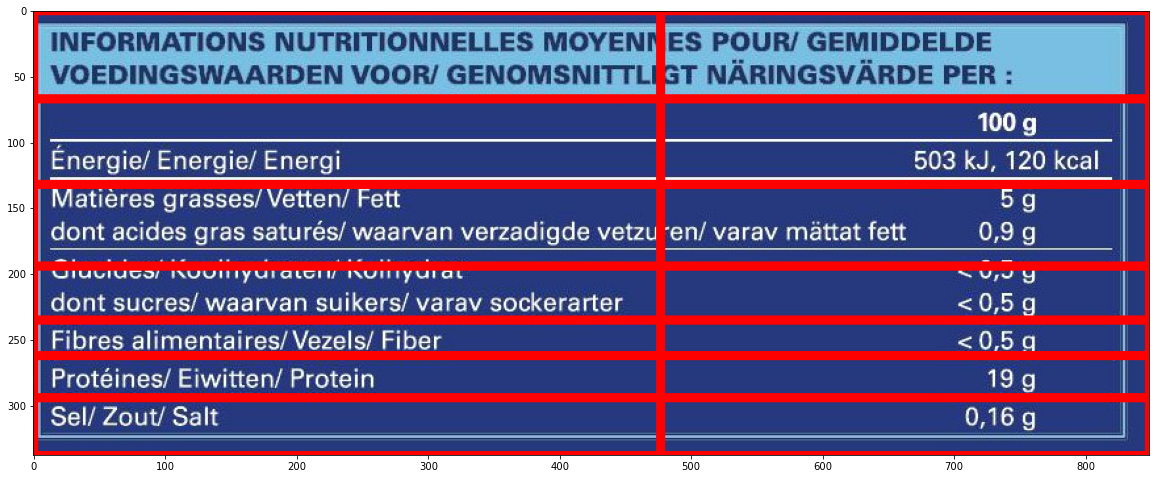

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(img)

In [14]:
mask = table.line_mask.astype(np.uint8)

In [24]:
with open(os.path.join('C:/Users/ytremenbert/fact-extraction/TableNet_notebooks/new_data_for_test/',"17e2c8a6-5565-44c0-96f1-0cadbea3b64b-1_cropped.json"), encoding='utf8') as file:
    loaded_file = json.load(file)
    ocr_json = loaded_file['textAnnotations'] #loaded_file['responses'][0]['textAnnotations']
    ocr = [Word(description=str(word['description']),
                         bounding_box=word['boundingPoly']['vertices']) for word in ocr_json
                   if all('x' in coordinate.keys() and 'y' in coordinate.keys() for coordinate in word['boundingPoly']['vertices']) and 'locale' not in word.keys()]
    #bounding_boxes = loaded_file['responses'][0]['textAnnotations']#[1:len(loaded_file['responses'][0]['textAnnotations'])]
    #print(ocr)
    for i, bounding_box in tqdm.tqdm(enumerate(ocr)):
        print(i, '->', bounding_box)
    #bounding_boxes = ocr["Word"]

89it [00:00, 3922.55it/s]

0 -> 'Word': INFORMATIONS, 'Bounding Box': [{'x': 14, 'y': 13}, {'x': 175, 'y': 13}, {'x': 175, 'y': 34}, {'x': 14, 'y': 34}], not included
1 -> 'Word': NUTRITIONNELLES, 'Bounding Box': [{'x': 185, 'y': 13}, {'x': 379, 'y': 13}, {'x': 379, 'y': 34}, {'x': 185, 'y': 34}], not included
2 -> 'Word': MOYENNES, 'Bounding Box': [{'x': 389, 'y': 13}, {'x': 507, 'y': 13}, {'x': 507, 'y': 34}, {'x': 389, 'y': 34}], not included
3 -> 'Word': POUR, 'Bounding Box': [{'x': 517, 'y': 13}, {'x': 573, 'y': 13}, {'x': 573, 'y': 34}, {'x': 517, 'y': 34}], not included
4 -> 'Word': /, 'Bounding Box': [{'x': 578, 'y': 13}, {'x': 581, 'y': 13}, {'x': 581, 'y': 34}, {'x': 578, 'y': 34}], not included
5 -> 'Word': GEMIDDELDE, 'Bounding Box': [{'x': 589, 'y': 13}, {'x': 728, 'y': 13}, {'x': 728, 'y': 34}, {'x': 589, 'y': 34}], not included
6 -> 'Word': VOEDINGSWAARDEN, 'Bounding Box': [{'x': 14, 'y': 36}, {'x': 234, 'y': 36}, {'x': 234, 'y': 59}, {'x': 14, 'y': 59}], not included
7 -> 'Word': VOOR, 'Bounding 

In [25]:
def circumscribed_rectangle(bounding_box):
    '''
    get circumscribed rectangle for this kind of bounding box
     ----------------
    |1-------------2|
    | \           / | 
    |   4--------3  |
    -----------------
    '''
    pt1 = bounding_box[0]
    pt2 = bounding_box[1]
    pt3 = bounding_box[2]
    pt4 = bounding_box[3]
    x1 = min(pt1['x'],pt4['x'])
    y1 = min(pt1['y'],pt2['y'])
    x2 = max(pt2['x'],pt3['x'])
    y2 = max(pt3['y'],pt4['y'])
    return Rectangle(x1,y1,x2,y2)

def dist(x1,x2):
    return abs(x1-x2)

def area(rect):
    l = rect.xmax-rect.xmin
    h = rect.ymax-rect.ymin
    return l*h


def intersection_area(rect1,rect2):
    dx = min(rect1.xmax, rect2.xmax) - max(rect1.xmin, rect2.xmin)
    dy = min(rect1.ymax, rect2.ymax) - max(rect1.ymin, rect2.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else:
        return 0

def dist_score(rect1,rect2):
    x1 = Rectangle
    x2 = rect2[0]
    l = rect1[2]
    return dist(x1,x2)/l

In [26]:
words = ocr.copy() #bounding_boxes -> ocr
shape = pipeline.images[-1].shape #(338, 849, 3)
table_shape = (np.array(table.table).shape[0],np.array(table.table).shape[1]) #(2, 6)
extracted_table = np.empty(shape=table_shape+(0,)).tolist()
for i, bounding_box in tqdm.tqdm(enumerate(ocr)): #bounding_boxes -> ocr
    try:
        done=False
        word_rect = circumscribed_rectangle(bounding_box.bounding_box)
        word_area = area(word_rect)
        for col_num,col in enumerate(table.table):
            col_x_min = col[0].xmin
            col_x_max = col[0].xmax
            column_rect = Rectangle(col_x_min,0,col_x_max,shape[1])
            inclusion_score = intersection_area(column_rect,word_rect)/word_area
            print('{} included in col {} with score of {}'.format(ocr[i].description,col_num,inclusion_score))
            if inclusion_score>0.5:
                for line_num,cell in enumerate(col):
                    inclusion_score = intersection_area(cell,word_rect)/word_area
                    if inclusion_score>0.5:
                        #bounding_boxes[i]['cell']= (line_num,col_num)
                        extracted_table[col_num][line_num].append(ocr[i].description)
                        done=True
                        
                        break
                if done:
                    break
        if col_num == len(table)-1 and line_num == len(col)-1:
            print(ocr[i].description)
                    
    except KeyboardInterrupt:
        print("Interrupted")
        break
    except:
        words.remove(bounding_box)

89it [00:00, 6907.72it/s]

INFORMATIONS included in col 0 with score of 1.0
NUTRITIONNELLES included in col 0 with score of 1.0
MOYENNES included in col 0 with score of 0.7457627118644068
POUR included in col 0 with score of 0.0
POUR included in col 1 with score of 1.0
/ included in col 0 with score of 0.0
/ included in col 1 with score of 1.0
GEMIDDELDE included in col 0 with score of 0.0
GEMIDDELDE included in col 1 with score of 1.0
VOEDINGSWAARDEN included in col 0 with score of 1.0
VOOR included in col 0 with score of 1.0
/ included in col 0 with score of 1.0
GENOMSNITTLIGT included in col 0 with score of 0.8571428571428571
NÄRINGSVÄRDE included in col 0 with score of 0.0
NÄRINGSVÄRDE included in col 1 with score of 1.0
PER included in col 0 with score of 0.0
PER included in col 1 with score of 1.0
: included in col 0 with score of 0.0
: included in col 1 with score of 1.0
100 included in col 0 with score of 0.0
100 included in col 1 with score of 1.0
g included in col 0 with score of 0.0
g included in col 

In [27]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100000)

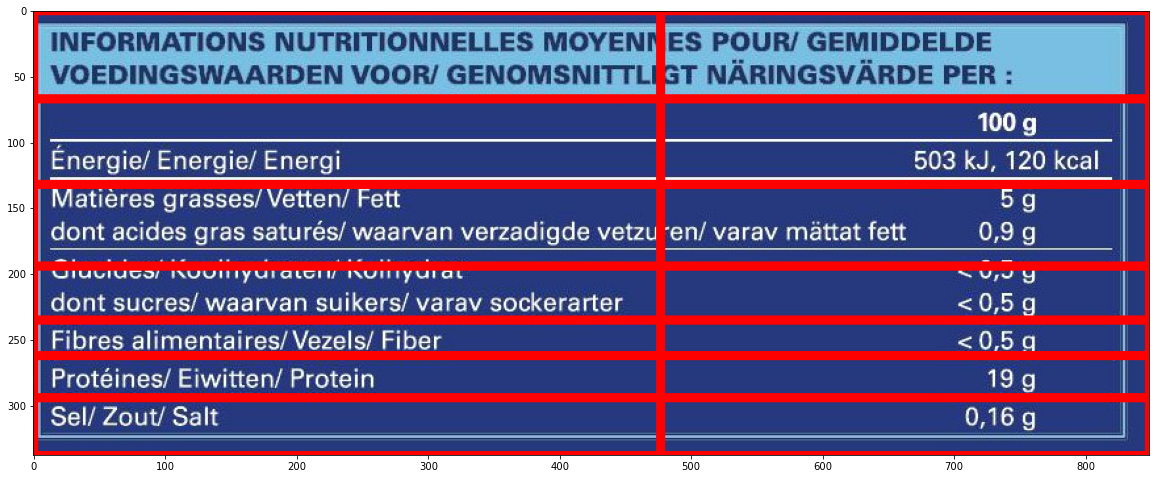

In [28]:
plt.figure(figsize=(20,10))
plt.imshow(img)

In [29]:
a = pd.DataFrame(extracted_table).applymap(lambda x: ' '.join(x)).T.replace('',np.nan)

In [30]:
a

,0,1
0,INFORMATIONS NUTRITIONNELLES MOYENNES VOEDINGS...,POUR / GEMIDDELDE NÄRINGSVÄRDE PER :
1,Énergie / Energie / Energi,"100 g 503 kJ , 120 kcal"
2,Matières grasses / Vetten / Fett dont acides g...,"5 g 0,9 g / varav mättat fett"
3,Glucides / Koolhydraten / Kolhydrat dont sucre...,"< 0,5 g < 0,5 g"
4,Fibres alimentaires / Vezels / Fiber,"< 0,5 g"
5,Protéines / Eiwitten / Protein,19 g
6,Sel / Zout / Salt,"0,16 g"


In [133]:
words = ocr.copy()
shape = pipeline.images[-1].shape
for i, bounding_box in tqdm.tqdm(enumerate(ocr)):
    try:
        done=False
        points = np.array([[[p['x'],p['y']] for p in bounding_box.bounding_box]])
        word_mask = cv2.fillPoly(np.zeros(shape),points,(255,255,255))
        for col_num,col in enumerate(table):
            column_mask = cv2.rectangle(np.zeros(shape),(columns[col_num],0),(columns[col_num+1],shape[1]),color=(255,255,255),thickness=-1)
            if inclusion_score(word_mask,column_mask)>0.5:
                for line_num,cell in enumerate(col):
                    column_mask = cv2.rectangle(np.zeros(shape),cell[0],cell[1],color=(255,255,255),thickness=-1)
                    if inclusion_score(word_mask,column_mask)>0.5:
                        #bounding_boxes[i]['cell']= (line_num,col_num)
                        extracted_table[col_num][line_num].append(ocr[i].description)
                        done=True
                        break
                if done:
                    break
                    
    except KeyboardInterrupt:
        print("Interrupted")
        break
    except:
        words.remove(bounding_box)

89it [00:00, 5223.15it/s]


In [134]:
words = ocr.copy()
shape = pipeline.images[-1].shape
for i, bounding_box in tqdm.tqdm(enumerate(ocr)):
    try:
        done=False
        points = np.array([[[p['x'],p['y']] for p in bounding_box.bounding_box]])
        word_mask = cv2.fillPoly(np.zeros(shape),points,(255,255,255))
        for col_num,col in enumerate(table.table):
            column_mask = cv2.rectangle(np.zeros(shape),(columns[col_num],0),(columns[col_num+1],shape[1]),color=(255,255,255),thickness=-1)
            if inclusion_score(word_mask,column_mask)>0.5:
                for line_num,cell in enumerate(col):
                    column_mask = cv2.rectangle(np.zeros(shape),cell[0],cell[1],color=(255,255,255),thickness=-1)
                    if inclusion_score(word_mask,column_mask)>0.5:
                        #bounding_boxes[i]['cell']= (line_num,col_num)
                        extracted_table[col_num][line_num].append(bounding_boxes[i].description)
                        done=True
                        break
                if done:
                    break
    except KeyboardInterrupt:
        print("You pressed ctrl c...")
        break
    except:
        words.remove(bounding_box)

89it [00:00, 5733.44it/s]


In [ ]:
with open('example.json','w') as file:
    json.dump(words, file)

In [ ]:
with open('example.json') as file:
    words = json.load(file)

In [ ]:
table = pd.DataFrame(words)
table.cell = table.cell.apply(lambda x: '-'.join(x))

In [ ]:
pd.DataFrame(words).groupby('cell')['text'].transform(lambda x: ','.join(x))

In [ ]:
column_mask_processor.peaks

In [ ]:
table[3]

In [ ]:
words = bounding_boxes.copy()
for i, bounding_box in tqdm.tqdm(enumerate(bounding_boxes)):
    try:
        for j,(x1,x2) in enumerate(column_mask_processor.column_areas[1:]):
            points = np.array([[[p['x'],p['y']] for p in bounding_box['bounding_box']]])
            shape = pipeline.images[-1].shape
            column_mask = cv2.rectangle(np.zeros(shape),(x1,0),(x2,shape[0]),color=(255,255,255),thickness=-1)
            word_mask = cv2.fillPoly(np.zeros(shape),points,(255,255,255))
            if inclusion_score(word_mask,column_mask)>0.5:
                bounding_boxes[i]['column']=j
                break
    except:
        pass

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(pipeline.images[-1])

In [ ]:
line = line_mask_processor.column_areas[1]

In [ ]:
img = cv2.rotate(rotated.copy(),cv2.ROTATE_90_CLOCKWISE)

In [ ]:
line_mask_processor.column_areas[3]

In [ ]:
signal = line_mask_processor.signal
signal_peaks = line_mask_processor.signal_peaks
plt.plot(signal)
plt.plot(signal_peaks, signal[signal_peaks], "x")
plt.plot(np.zeros_like(signal), "--", color="gray")

In [ ]:
for line in line_mask_processor.column_areas:
    cv2.line(img,(0,line[0]),(img.shape[1],line[0]),color=(255,0,0))

In [ ]:
plt.imshow(img)

In [ ]:
for i, bounding_box in tqdm.tqdm(enumerate(bounding_boxes)):
    try:
        for j,(x1,x2) in enumerate(line_mask_processor.column_areas[1:]):
            points = np.array([[[p['x'],p['y']] for p in bounding_box['bounding_box']]])
            shape = pipeline.images[-1].shape
            column_mask = cv2.rectangle(np.zeros(shape),(0,x1),(shape[0],x2),color=(255,255,255),thickness=-1)
            word_mask = cv2.fillPoly(np.zeros(shape),points,(255,255,255))
            #print("{} : {}".format(bounding_box['text'],inclusion_score(word_mask,column_mask)))
            if inclusion_score(word_mask,column_mask)>0.5:
                bounding_boxes[i]['line']=j
                break
    except:
        pass

In [ ]:
for image in tqdm.tqdm(images):
    try:
        pipeline = Pipeline(model,tf.image.decode_jpeg((tf.io.read_file(image))))
        pipeline.run(0.8)
        plt.imsave(os.path.join('../results/table_detected/',image.split('/')[-1]),pipeline.images[-1].numpy())
      #  column_mask_processor = ColumnMaskProcessor(pipeline.images[-1],pipeline.predicted_column_masks[-1].numpy().reshape(256,256).astype('uint8'))
      #  column_mask_processor.process_mask()
      #  column_mask_processor.get_peaks(20,25)
      #  column_mask_processor.find_column_areas()
        
      #  pipeline.tm_list[-1].draw_bounding_box()
      #  plt.figure(figsize=(10,5))
      #  plt.title("Original Image")
      #  plt.imshow(pipeline.tm_list[0].image)
      #  plt.figure(figsize=(10,5))
      #  plt.title("Detected Table")
      #  plt.imshow(pipeline.tm_list[-1].image_with_bounding_box)
      #  plt.figure(figsize=(5,1))
      #  plt.plot(column_mask_processor.signal)
      #  plt.plot(column_mask_processor.signal_peaks, column_mask_processor.signal[column_mask_processor.signal_peaks], "x")
      #  plt.plot(np.zeros_like(column_mask_processor.signal), "--", color="gray")
      #  plt.show()
      #  
      #  plt.figure(figsize=(20,10))
      #  for num, area in enumerate(column_mask_processor.column_areas):
      #      plt.subplot(1,len(column_mask_processor.column_areas),num+1)
      #      plt.title("column {}".format(num))
      #      plt.axis('off')
      #      plt.imshow(area)
      #      plt.imsave(os.path.join('../data/line_detection_data/',image.split('/')[-1]),cv2.rotate(pipeline.images[-1].numpy(), cv2.ROTATE_90_CLOCKWISE))
    except:
        pass